# Getting started with Word2Vec in Gensim and making it work!

The idea behind Word2Vec is pretty simple. We are making and assumption that you can tell the meaning of a word by the company it keeps. This is analogous to the saying *show me your friends, and I'll tell who you are*. So if you have two words that have very similar neighbors (i.e. the usage context is about the same), then these words are probably quite similar in meaning or are at least highly related. For example, the words `shocked`,`appalled` and `astonished` are typically used in a similar context. 

In this tutorial, you will learn how to use the Gensim implementation of Word2Vec and actually get it to work! I have heard a lot of complaints about poor performance etc, but its really a combination of two things, (1) your input data and (2) your parameter settings. Note that the training algorithms in this package were ported from the [original Word2Vec implementation by Google](https://arxiv.org/pdf/1301.3781.pdf) and extended with additional functionality.

### Imports and logging

First, we start with our imports and get logging established:

In [31]:
# imports needed and set up logging
import gzip
import gensim 
import logging

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


### Dataset 
Next, is our dataset. The secret to getting Word2Vec really working for you is to have lots and lots of text data. In this case I am going to use data from the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset. This dataset has full user reviews of cars and hotels. I have specifically concatenated all of the hotel reviews into one big file which is about 97MB compressed and 229MB uncompressed. We will use the compressed file for this tutorial. Each line in this file represents a hotel review. You can download the OpinRank Word2Vec dataset here.

To avoid confusion, while gensim’s word2vec tutorial says that you need to pass it a sequence of sentences as its input, you can always pass it a whole review as a sentence (i.e. a much larger size of text), and it should not make much of a difference. 

Now, let's take a closer look at this data below by printing the first line. You can see that this is a pretty hefty review.

In [2]:
data_file="reviews_data.txt.gz"

with gzip.open ('reviews_data.txt.gz', 'rb') as f:
    for i,line in enumerate (f):
        print(line)
        break


b"Oct 12 2009 \tNice trendy hotel location not too bad.\tI stayed in this hotel for one night. As this is a fairly new place some of the taxi drivers did not know where it was and/or did not want to drive there. Once I have eventually arrived at the hotel, I was very pleasantly surprised with the decor of the lobby/ground floor area. It was very stylish and modern. I found the reception's staff geeting me with 'Aloha' a bit out of place, but I guess they are briefed to say that to keep up the coroporate image.As I have a Starwood Preferred Guest member, I was given a small gift upon-check in. It was only a couple of fridge magnets in a gift box, but nevertheless a nice gesture.My room was nice and roomy, there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by 'bliss'.The location is not great. It is at the last metro stop and you then need to take a taxi, but if you are not planning on going to see the historic sites in Be

### Read files into a list
Now that we've had a sneak peak of our dataset, we can read it into a list so that we can pass this on to the Word2Vec model. Notice in the code below, that I am directly reading the 
compressed file. I'm also doing a mild pre-processing of the reviews using `gensim.utils.simple_preprocess (line)`. This does some basic pre-processing such as tokenization, lowercasing, etc and returns back a list of tokens (words). Documentation of this pre-processing method can be found on the official [Gensim documentation site](https://radimrehurek.com/gensim/utils.html). 



In [3]:

def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open (input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
            yield gensim.utils.simple_preprocess (line)

# read the tokenized reviews into a list
# each review item becomes a serries of words
# so this becomes a list of lists
documents = list (read_input (data_file))
logging.info ("Done reading data file")    

2018-05-05 09:03:01,162 : INFO : reading file reviews_data.txt.gz...this may take a while
2018-05-05 09:03:01,164 : INFO : read 0 reviews
2018-05-05 09:03:03,799 : INFO : read 10000 reviews
2018-05-05 09:03:06,359 : INFO : read 20000 reviews
2018-05-05 09:03:09,632 : INFO : read 30000 reviews
2018-05-05 09:03:12,335 : INFO : read 40000 reviews
2018-05-05 09:03:15,256 : INFO : read 50000 reviews
2018-05-05 09:03:18,108 : INFO : read 60000 reviews
2018-05-05 09:03:20,534 : INFO : read 70000 reviews
2018-05-05 09:03:22,707 : INFO : read 80000 reviews
2018-05-05 09:03:26,570 : INFO : read 90000 reviews
2018-05-05 09:03:29,995 : INFO : read 100000 reviews
2018-05-05 09:03:32,323 : INFO : read 110000 reviews
2018-05-05 09:03:35,092 : INFO : read 120000 reviews
2018-05-05 09:03:37,416 : INFO : read 130000 reviews
2018-05-05 09:03:40,316 : INFO : read 140000 reviews
2018-05-05 09:03:42,695 : INFO : read 150000 reviews
2018-05-05 09:03:45,136 : INFO : read 160000 reviews
2018-05-05 09:03:47,600

## Training the Word2Vec model

Training the model is fairly straightforward. You just instantiate Word2Vec and pass the reviews that we read in the previous step (the `documents`). So, we are essentially passing on a list of lists. Where each list within the main list contains a set of tokens from a user review. Word2Vec uses all these tokens to internally create a vocabulary. And by vocabulary, I mean a set of unique words.

After building the vocabulary, we just need to call `train(...)` to start training the Word2Vec model. Training on the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset takes about 10 minutes so please be patient while running your code on this dataset.

Behind the scenes we are actually training a simple neural network with a single hidden layer. But, we are actually not going to use the neural network after training. Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn. 

In [4]:
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
model.train(documents,total_examples=len(documents),epochs=10)

2018-05-05 09:04:38,819 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-05-05 09:04:38,821 : INFO : collecting all words and their counts
2018-05-05 09:04:38,822 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-05 09:04:39,126 : INFO : PROGRESS: at sentence #10000, processed 1655714 words, keeping 25777 word types
2018-05-05 09:04:39,412 : INFO : PROGRESS: at sentence #20000, processed 3317863 words, keeping 35016 word types
2018-05-05 09:04:39,757 : INFO : PROGRESS: at sentence #30000, processed 5264072 words, keeping 47518 word types
2018-05-05 09:04:40,160 : INFO : PROGRESS: at sentence #40000, processed 7081746 words, keeping 56675 word types
2018-05-05 09:04:40,506 : INFO : PROGRESS: at sentence #50000, processed 9089491 words, keeping 63744 word types
2018-05-05 09:04:40,852 : INFO : PROGRESS: at sentence #60000, processed 11013723 words, keeping 76781 word types
2018-05-05 09:04:41,135 : INFO : PROGRESS: a

2018-05-05 09:05:26,782 : INFO : EPOCH 1 - PROGRESS: at 74.17% examples, 600001 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:05:27,798 : INFO : EPOCH 1 - PROGRESS: at 75.73% examples, 596938 words/s, in_qsize 17, out_qsize 2
2018-05-05 09:05:28,805 : INFO : EPOCH 1 - PROGRESS: at 77.25% examples, 594100 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:05:29,855 : INFO : EPOCH 1 - PROGRESS: at 79.23% examples, 593962 words/s, in_qsize 20, out_qsize 1
2018-05-05 09:05:30,893 : INFO : EPOCH 1 - PROGRESS: at 81.30% examples, 594527 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:05:31,907 : INFO : EPOCH 1 - PROGRESS: at 83.29% examples, 594093 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:05:32,916 : INFO : EPOCH 1 - PROGRESS: at 84.91% examples, 592362 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:05:33,917 : INFO : EPOCH 1 - PROGRESS: at 86.81% examples, 591356 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:05:34,937 : INFO : EPOCH 1 - PROGRESS: at 88.20% examples, 586550 words/s,

2018-05-05 09:06:31,807 : INFO : EPOCH 2 - PROGRESS: at 86.66% examples, 527037 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:06:32,820 : INFO : EPOCH 2 - PROGRESS: at 88.51% examples, 526622 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:06:33,820 : INFO : EPOCH 2 - PROGRESS: at 90.60% examples, 527899 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:06:34,821 : INFO : EPOCH 2 - PROGRESS: at 92.74% examples, 529620 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:06:35,865 : INFO : EPOCH 2 - PROGRESS: at 94.74% examples, 530334 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:06:36,895 : INFO : EPOCH 2 - PROGRESS: at 96.23% examples, 528430 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:06:37,899 : INFO : EPOCH 2 - PROGRESS: at 98.02% examples, 528061 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:06:38,789 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-05-05 09:06:38,803 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-05-05 09:06:38,

2018-05-05 09:07:34,057 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-05-05 09:07:34,064 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-05-05 09:07:34,087 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-05-05 09:07:34,095 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-05-05 09:07:34,103 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-05 09:07:34,115 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-05 09:07:34,129 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-05 09:07:34,131 : INFO : EPOCH - 3 : training on 41519355 raw words (30349711 effective words) took 55.3s, 549299 effective words/s
2018-05-05 09:07:35,174 : INFO : EPOCH 4 - PROGRESS: at 1.61% examples, 493771 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:07:36,210 : INFO : EPOCH 4 - PROGRESS: at 3.69% examples, 553006 words/s, in_qsize 19, out_qsize

2018-05-05 09:08:32,902 : INFO : EPOCH 5 - PROGRESS: at 2.98% examples, 459429 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:08:33,918 : INFO : EPOCH 5 - PROGRESS: at 4.71% examples, 479499 words/s, in_qsize 15, out_qsize 4
2018-05-05 09:08:34,920 : INFO : EPOCH 5 - PROGRESS: at 6.69% examples, 511985 words/s, in_qsize 15, out_qsize 4
2018-05-05 09:08:35,938 : INFO : EPOCH 5 - PROGRESS: at 8.66% examples, 531290 words/s, in_qsize 14, out_qsize 5
2018-05-05 09:08:36,951 : INFO : EPOCH 5 - PROGRESS: at 10.34% examples, 545557 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:08:37,969 : INFO : EPOCH 5 - PROGRESS: at 11.96% examples, 554430 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:08:38,978 : INFO : EPOCH 5 - PROGRESS: at 13.62% examples, 554694 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:08:39,990 : INFO : EPOCH 5 - PROGRESS: at 14.72% examples, 535669 words/s, in_qsize 15, out_qsize 4
2018-05-05 09:08:40,998 : INFO : EPOCH 5 - PROGRESS: at 16.05% examples, 527423 words/s, in_

2018-05-05 09:09:34,866 : INFO : EPOCH 1 - PROGRESS: at 12.93% examples, 523362 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:09:35,872 : INFO : EPOCH 1 - PROGRESS: at 14.63% examples, 527948 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:09:36,933 : INFO : EPOCH 1 - PROGRESS: at 16.05% examples, 521343 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:09:37,945 : INFO : EPOCH 1 - PROGRESS: at 17.71% examples, 529447 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:09:38,948 : INFO : EPOCH 1 - PROGRESS: at 19.25% examples, 532812 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:09:39,968 : INFO : EPOCH 1 - PROGRESS: at 20.38% examples, 524808 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:09:40,980 : INFO : EPOCH 1 - PROGRESS: at 21.97% examples, 522674 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:09:42,022 : INFO : EPOCH 1 - PROGRESS: at 23.51% examples, 526128 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:09:43,025 : INFO : EPOCH 1 - PROGRESS: at 25.29% examples, 530816 words/s,

2018-05-05 09:10:39,813 : INFO : EPOCH 2 - PROGRESS: at 25.55% examples, 573029 words/s, in_qsize 15, out_qsize 4
2018-05-05 09:10:40,824 : INFO : EPOCH 2 - PROGRESS: at 27.74% examples, 573395 words/s, in_qsize 20, out_qsize 5
2018-05-05 09:10:41,829 : INFO : EPOCH 2 - PROGRESS: at 29.94% examples, 575875 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:10:42,862 : INFO : EPOCH 2 - PROGRESS: at 31.99% examples, 573758 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:10:43,929 : INFO : EPOCH 2 - PROGRESS: at 34.22% examples, 576033 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:10:44,937 : INFO : EPOCH 2 - PROGRESS: at 36.48% examples, 579069 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:10:45,954 : INFO : EPOCH 2 - PROGRESS: at 38.55% examples, 578788 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:10:46,968 : INFO : EPOCH 2 - PROGRESS: at 40.82% examples, 581578 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:10:47,970 : INFO : EPOCH 2 - PROGRESS: at 42.93% examples, 581260 words/s,

2018-05-05 09:11:44,479 : INFO : EPOCH 3 - PROGRESS: at 46.00% examples, 523394 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:11:45,490 : INFO : EPOCH 3 - PROGRESS: at 47.37% examples, 519498 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:11:46,521 : INFO : EPOCH 3 - PROGRESS: at 49.32% examples, 519668 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:11:47,525 : INFO : EPOCH 3 - PROGRESS: at 51.15% examples, 520257 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:11:48,537 : INFO : EPOCH 3 - PROGRESS: at 52.95% examples, 521304 words/s, in_qsize 13, out_qsize 6
2018-05-05 09:11:49,559 : INFO : EPOCH 3 - PROGRESS: at 54.53% examples, 519616 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:11:50,560 : INFO : EPOCH 3 - PROGRESS: at 56.56% examples, 520899 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:11:51,610 : INFO : EPOCH 3 - PROGRESS: at 58.44% examples, 520965 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:11:52,613 : INFO : EPOCH 3 - PROGRESS: at 60.45% examples, 522563 words/s,

2018-05-05 09:12:49,636 : INFO : EPOCH 4 - PROGRESS: at 50.56% examples, 499346 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:12:50,640 : INFO : EPOCH 4 - PROGRESS: at 51.67% examples, 493854 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:12:51,650 : INFO : EPOCH 4 - PROGRESS: at 52.95% examples, 491203 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:12:52,691 : INFO : EPOCH 4 - PROGRESS: at 54.84% examples, 492936 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:12:53,715 : INFO : EPOCH 4 - PROGRESS: at 56.34% examples, 490128 words/s, in_qsize 20, out_qsize 2
2018-05-05 09:12:54,718 : INFO : EPOCH 4 - PROGRESS: at 57.91% examples, 489135 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:12:55,727 : INFO : EPOCH 4 - PROGRESS: at 59.70% examples, 489641 words/s, in_qsize 18, out_qsize 1
2018-05-05 09:12:56,761 : INFO : EPOCH 4 - PROGRESS: at 61.32% examples, 488752 words/s, in_qsize 20, out_qsize 2
2018-05-05 09:12:57,764 : INFO : EPOCH 4 - PROGRESS: at 62.95% examples, 488425 words/s,

2018-05-05 09:13:53,861 : INFO : EPOCH 5 - PROGRESS: at 69.61% examples, 581989 words/s, in_qsize 14, out_qsize 5
2018-05-05 09:13:54,867 : INFO : EPOCH 5 - PROGRESS: at 71.59% examples, 582555 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:13:55,880 : INFO : EPOCH 5 - PROGRESS: at 73.72% examples, 582760 words/s, in_qsize 20, out_qsize 1
2018-05-05 09:13:56,884 : INFO : EPOCH 5 - PROGRESS: at 75.66% examples, 583267 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:13:57,933 : INFO : EPOCH 5 - PROGRESS: at 77.62% examples, 583759 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:13:58,957 : INFO : EPOCH 5 - PROGRESS: at 79.65% examples, 584451 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:13:59,970 : INFO : EPOCH 5 - PROGRESS: at 81.67% examples, 585101 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:14:00,970 : INFO : EPOCH 5 - PROGRESS: at 83.67% examples, 585385 words/s, in_qsize 17, out_qsize 2
2018-05-05 09:14:01,980 : INFO : EPOCH 5 - PROGRESS: at 85.62% examples, 585964 words/s,

2018-05-05 09:14:58,982 : INFO : EPOCH 6 - PROGRESS: at 82.91% examples, 512088 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:14:59,992 : INFO : EPOCH 6 - PROGRESS: at 84.89% examples, 514358 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:15:01,038 : INFO : EPOCH 6 - PROGRESS: at 87.00% examples, 515656 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:15:02,136 : INFO : EPOCH 6 - PROGRESS: at 89.12% examples, 516153 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:15:03,172 : INFO : EPOCH 6 - PROGRESS: at 91.33% examples, 517883 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:15:04,179 : INFO : EPOCH 6 - PROGRESS: at 93.38% examples, 519547 words/s, in_qsize 20, out_qsize 1
2018-05-05 09:15:05,223 : INFO : EPOCH 6 - PROGRESS: at 95.56% examples, 520961 words/s, in_qsize 20, out_qsize 1
2018-05-05 09:15:06,236 : INFO : EPOCH 6 - PROGRESS: at 97.45% examples, 521422 words/s, in_qsize 20, out_qsize 2
2018-05-05 09:15:07,241 : INFO : EPOCH 6 - PROGRESS: at 99.58% examples, 522973 words/s,

2018-05-05 09:16:01,692 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-05-05 09:16:01,706 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-05-05 09:16:01,710 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-05-05 09:16:01,732 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-05-05 09:16:01,740 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-05-05 09:16:01,751 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-05-05 09:16:01,763 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-05 09:16:01,769 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-05 09:16:01,778 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-05 09:16:01,779 : INFO : EPOCH - 7 : training on 41519355 raw words (30349809 effective words) took 54.3s, 558706 effective words/s
2018-05-05 09:16:02,845 : INFO : EPOCH 8 

2018-05-05 09:16:58,961 : INFO : EPOCH 9 - PROGRESS: at 5.70% examples, 583796 words/s, in_qsize 20, out_qsize 2
2018-05-05 09:17:00,007 : INFO : EPOCH 9 - PROGRESS: at 7.51% examples, 571538 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:17:01,007 : INFO : EPOCH 9 - PROGRESS: at 9.08% examples, 559448 words/s, in_qsize 20, out_qsize 1
2018-05-05 09:17:02,015 : INFO : EPOCH 9 - PROGRESS: at 10.61% examples, 559036 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:17:03,021 : INFO : EPOCH 9 - PROGRESS: at 11.96% examples, 554522 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:17:04,024 : INFO : EPOCH 9 - PROGRESS: at 13.80% examples, 564107 words/s, in_qsize 18, out_qsize 1
2018-05-05 09:17:05,032 : INFO : EPOCH 9 - PROGRESS: at 15.50% examples, 564215 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:17:06,075 : INFO : EPOCH 9 - PROGRESS: at 17.20% examples, 568114 words/s, in_qsize 20, out_qsize 1
2018-05-05 09:17:07,075 : INFO : EPOCH 9 - PROGRESS: at 18.88% examples, 571935 words/s, in

2018-05-05 09:18:04,086 : INFO : EPOCH 10 - PROGRESS: at 25.40% examples, 566378 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:18:05,092 : INFO : EPOCH 10 - PROGRESS: at 27.32% examples, 562906 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:18:06,096 : INFO : EPOCH 10 - PROGRESS: at 29.34% examples, 562332 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:18:07,146 : INFO : EPOCH 10 - PROGRESS: at 31.48% examples, 562042 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:18:08,149 : INFO : EPOCH 10 - PROGRESS: at 33.60% examples, 564519 words/s, in_qsize 18, out_qsize 1
2018-05-05 09:18:09,154 : INFO : EPOCH 10 - PROGRESS: at 35.65% examples, 566157 words/s, in_qsize 18, out_qsize 1
2018-05-05 09:18:10,168 : INFO : EPOCH 10 - PROGRESS: at 37.63% examples, 565925 words/s, in_qsize 19, out_qsize 0
2018-05-05 09:18:11,215 : INFO : EPOCH 10 - PROGRESS: at 39.92% examples, 568069 words/s, in_qsize 20, out_qsize 0
2018-05-05 09:18:12,215 : INFO : EPOCH 10 - PROGRESS: at 42.22% examples, 569937

(303489446, 415193550)

## Lets save our model
This way we can reuse it, instead of re-training it everytime.

In [10]:
# By default, the model is saved in a binary format to save space.
# But they can also be stored as text-files in ASCII
model.wv.save_word2vec_format('model.bin')

# Loading the model from disk
#model = Word2Vec.load('model.bin')

2018-05-05 09:25:21,528 : INFO : storing 70538x150 projection weights into model.bin


## Google News word2vec model

Man kann auch das von Google trainierte model verwenden. Ist jedoch 1.53 GB gross!

In [ ]:
#from gensim.models import KeyedVectors
#filename = 'GoogleNews-vectors-negative300.bin'
#model = KeyedVectors.load_word2vec_format(filename, binary=True)

## Now, let's look at some output 
This first example shows a simple case of looking up words similar to the word `dirty`. All we need to do here is to call the `most_similar` function and provide the word `dirty` as the positive example. This returns the top 10 similar words. 

In [12]:

w1 = "dirty"
model.wv.most_similar (positive=w1)


[('filthy', 0.8729924559593201),
 ('stained', 0.7865322232246399),
 ('dusty', 0.7792858481407166),
 ('grubby', 0.7714115381240845),
 ('unclean', 0.7646351456642151),
 ('smelly', 0.758938193321228),
 ('soiled', 0.7325705289840698),
 ('disgusting', 0.7318438291549683),
 ('gross', 0.7208217978477478),
 ('dingy', 0.7195594906806946)]

That looks pretty good, right? Let's look at a few more. Let's look at similarity for `polite`, `france` and `shocked`. 

In [6]:
# look up top 6 words similar to 'polite'
w1 = ["polite"]
model.wv.most_similar (positive=w1,topn=6)


[('courteous', 0.9235456585884094),
 ('friendly', 0.8373810052871704),
 ('cordial', 0.8073591589927673),
 ('professional', 0.7918747067451477),
 ('curteous', 0.7916375994682312),
 ('attentive', 0.7660061717033386)]

In [7]:
# look up top 6 words similar to 'france'
w1 = ["france"]
model.wv.most_similar (positive=w1,topn=6)


[('canada', 0.6653457880020142),
 ('spain', 0.6385778784751892),
 ('germany', 0.6260266304016113),
 ('greece', 0.6113550066947937),
 ('mexico', 0.6109868288040161),
 ('hawaii', 0.5874741077423096)]

In [8]:
# look up top 6 words similar to 'shocked'
w1 = ["shocked"]
model.wv.most_similar (positive=w1,topn=6)


[('horrified', 0.8209675550460815),
 ('astonished', 0.7912657260894775),
 ('dismayed', 0.7703760266304016),
 ('amazed', 0.7702016234397888),
 ('stunned', 0.7682645916938782),
 ('appalled', 0.7657837271690369)]

That's, nice. You can even specify several positive examples to get things that are related in the provided context and provide negative examples to say what should not be considered as related. In the example below we are asking for all items that *relate to bed* only:

In [9]:
# get everything related to stuff on the bed
w1 = ["bed",'sheet','pillow']
w2 = ['couch']
model.wv.most_similar (positive=w1,negative=w2,topn=10)


[('duvet', 0.7105757594108582),
 ('mattress', 0.7079187035560608),
 ('blanket', 0.6926605701446533),
 ('matress', 0.6891182065010071),
 ('quilt', 0.678297758102417),
 ('pillowcase', 0.6495039463043213),
 ('sheets', 0.637366533279419),
 ('pillows', 0.6340519189834595),
 ('foam', 0.6278765201568604),
 ('coverlet', 0.613230288028717)]

### Similarity between two words in the vocabulary

You can even use the Word2Vec model to return the similarity between two words that are present in the vocabulary. 

In [13]:
# similarity between two different words
model.wv.similarity(w1="dirty",w2="smelly")

0.7589382837917122

In [14]:
# similarity between two identical words
model.wv.similarity(w1="dirty",w2="dirty")

0.9999999999999999

In [15]:
# similarity between two unrelated words
model.wv.similarity(w1="dirty",w2="clean")

0.2678140006831611

Under the hood, the above three snippets computes the cosine similarity between the two specified words using word vectors of each. From the scores, it makes sense that `dirty` is highly similar to `smelly` but `dirty` is dissimilar to `clean`. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0]. You can read more about cosine similarity scoring [here](https://en.wikipedia.org/wiki/Cosine_similarity).

### Find the odd one out
You can even use Word2Vec to find odd items given a list of items.

In [16]:
# Which one is the odd one out in this list?
model.wv.doesnt_match(["cat","dog","france"])

'france'

In [17]:
# Which one is the odd one out in this list?
model.wv.doesnt_match(["bed","pillow","duvet","shower"])


'shower'

## Visualizing

In [18]:
# retrieve all of the vectors from a trained model
X = model[model.wv.vocab]

C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
# create a 2-dimensional PCA model of the word vectors
# because we can't visualize a matrix with so many dimensions
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [32]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, result[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [33]:
points.head(10)

,word,x,y
0,oct,2.542390,-1.956581
1,nice,1.700541,10.310646
2,trendy,3.978720,1.457141
3,hotel,-3.830312,-4.469841
4,location,4.181920,-7.917624
5,not,0.155593,2.116962
6,too,-4.227326,-2.616014
7,bad,-1.181960,6.108256
8,stayed,0.945933,5.965499
9,in,17.422297,3.290045


In [34]:
sns.set_context("poster")

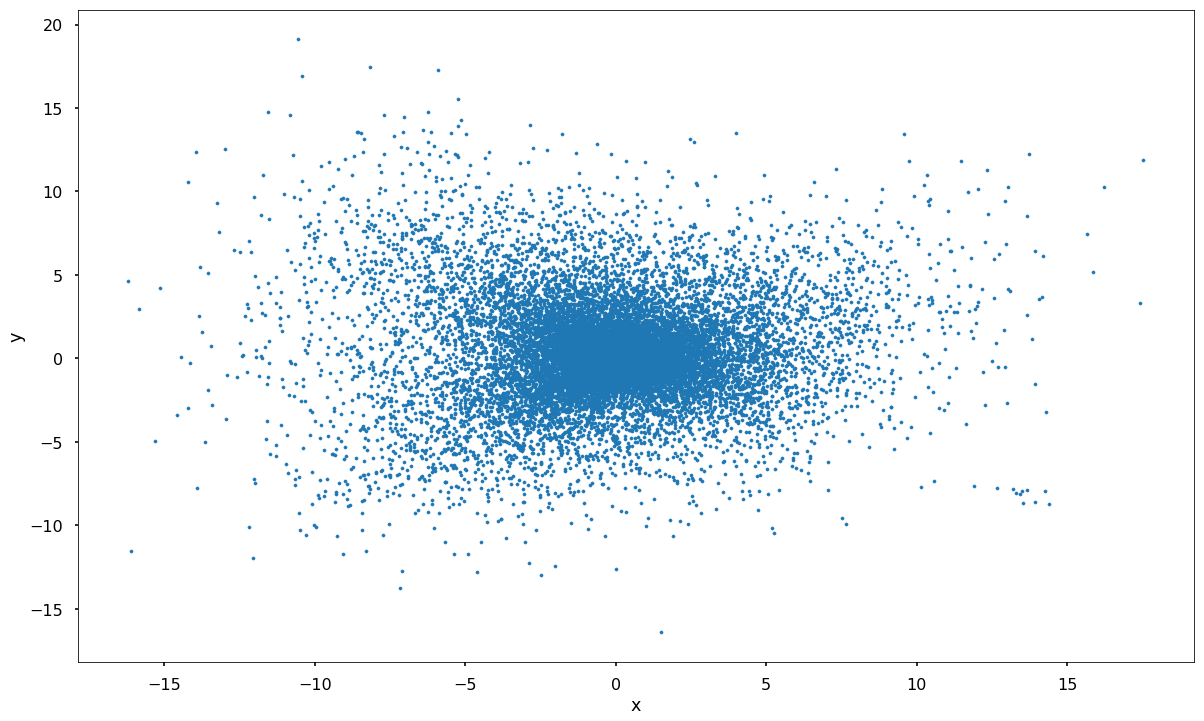

In [35]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [77]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
def plot_around_word(word, offset = 1):
    s = points[(points['word'] == word)]
    x = float(s['x'])
    y = float(s['y'])
    
    x_bounds = (x - (offset / 2), x + (offset / 2))
    y_bounds = (y - (offset / 2), y + (offset / 2))
    
    print('x_bounds', x_bounds)
    print('x_bounds', y_bounds)
    
    plot_region(x_bounds, y_bounds)

In [ ]:
s = points[(points['grown'] == 'dirty')]
print(s)

In [ ]:
plot_around_word('grown', 0.5)

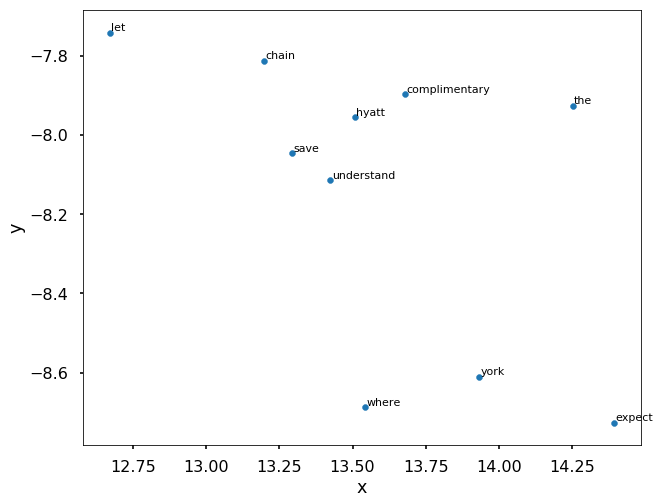

In [39]:
plot_region(x_bounds=(12.0, 15), y_bounds=(-11, -7))

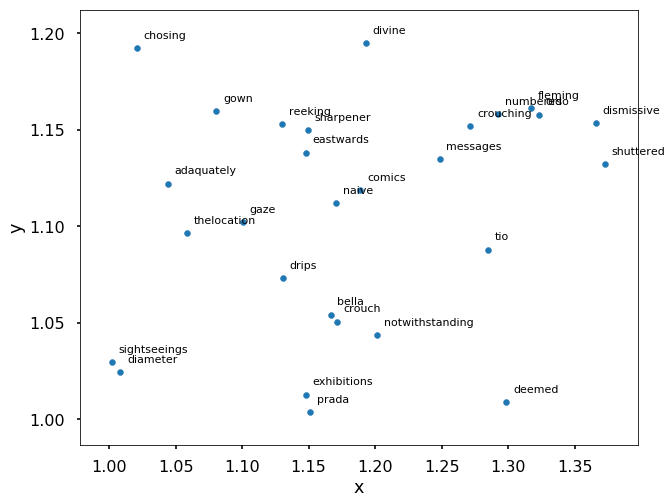

In [43]:
plot_region(x_bounds=(1, 1.4), y_bounds=(1, 1.2))

## Understanding some of the parameters
To train the model earlier, we had to set some parameters. Now, let's try to understand what some of them mean. For reference, this is the command that we used to train the model.

```
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
```

### `size`
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me. 

### `window`
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window. 

### `min_count`
Minimium frequency count of words. The model would ignore words that do not statisfy the `min_count`. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

### `workers`
How many threads to use behind the scenes?


## When should you use Word2Vec?

There are many application scenarios for Word2Vec. Imagine if you need to build a sentiment lexicon. Training a Word2Vec model on large amounts of user reviews helps you achieve that. You have a lexicon for not just sentiment, but for most words in the vocabulary. 

Beyond, raw unstructured text data, you could also use Word2Vec for more structured data. For example, if you had tags for a million stackoverflow questions and answers, you could find tags that are related to a given tag and recommend the related ones for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. Granted, you still need a large number of examples to make it work. 
